# **03 – Model Prototyping (MP)**

**Source**

This notebook starts from the model-ready feature matrix and feature specification produced by the Feature Engineering stage. No raw data manipulation or feature construction occurs here.

**Goals**

- Train and evaluate a Probability of Default (PD) model using a fixed, versioned feature set
- Preserve a strict separation of concerns between:
Feature engineering (input representation)
Modeling (learning, inference, evaluation)
Serving (deployment and monitoring)
- Ensure all modeling steps are:
Reproducible
Deterministic (given seeds and inputs)
Fully auditable
- Prevent data leakage by:
Enforcing time-aware data splits
Using only features available at prediction time
- Produce well-calibrated probability estimates, not just rankings
- Support multiple model families while maintaining a consistent evaluation protocol
- Enable clean promotion of a trained model artifact to production
- Establish a baseline for future experimentation via explicit model versioning

**To-Do Checklist**

1. Inputs & Modeling Contracts
- Load feature matrix generated from feature build script
- Load feature specification (versioned)
- Verify feature set matches spec exactly
- Confirm target column presence and name
- Fail early if schema mismatch is detected

2. Prediction Problem Freeze
- Confirm PD definition (binary default indicator)
- Confirm prediction horizon (e.g., 12-month default)
- Verify Point-in-Time (PIT) vs Through-the-Cycle (TTC) framing
- Freeze target definition for this experiment
- Document assumptions explicitly

3. Data Splitting Strategy
- Define train / validation / test splits
- Use time-based splitting where applicable
- Ensure no leakage across temporal boundaries
- Validate class balance across splits
- Log split sizes and date cutoffs

4. Baseline Model
- Train a simple baseline (e.g., logistic regression)
- Establish baseline ROC-AUC, PR-AUC, and Brier score
- Verify pipeline correctness
- Record baseline performance for comparison

5. Primary Model Training
- Select primary model class (e.g., gradient-boosted trees)
- Define hyperparameter search space
- Fix random seeds
- Train model using training split only
- Evaluate on validation set only
- Prevent peeking at test data

6. Hyperparameter Tuning
- Choose tuning strategy (grid / random / Bayesian)
- Optimize against a primary metric (e.g., ROC-AUC)
- Track secondary metrics (PR-AUC, log loss)
- Record best configuration
- Avoid over-tuning on validation data

7. Model Evaluation
- Compute ROC-AUC
- Compute PR-AUC
- Compute Brier score
- Generate ROC and PR curves
- Generate confusion matrix at reference thresholds
- Evaluate performance on held-out test set

8. Probability Calibration
- Assess calibration curve
- Compare raw vs calibrated probabilities
- Apply calibration method if needed (Platt / Isotonic)
- Re-evaluate calibration metrics
- Document calibration choice

9. Model Interpretability
- Extract global feature importance
- Validate importance stability
- Produce local explanations (if applicable)
- Sanity-check sign and magnitude of effects
- Ensure interpretability aligns with credit risk intuition

10. Stability & Robustness Checks
- Evaluate performance across time slices
- Check sensitivity to small perturbations
- Identify brittle features
- Document known failure modes

11. Model Selection & Freezing
- Select final model based on validation + test results
- Freeze model configuration
- Assign explicit model version
- Save model artifact
- Save metadata (metrics, feature spec hash, training window)

12. Handoff to Serving
- Validate inference on sample payloads
- Ensure feature ordering consistency
- Export model in serving-ready format
- Confirm compatibility with API schema
- Document deployment assumptions

# 1. Inputs & Modeling Contracts

In [1]:
import sys
from importlib import reload
from pathlib import Path

# Add project root to path if not already present
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import and reload to pick up any code changes
from src.models import load as load_module

reload(load_module)
from src.models.load import load_modeling_inputs

mi = load_modeling_inputs(
    artifacts_dir="../data/_artifacts_preview",
    fe_parquet_name="engineered_features.parquet",
    feature_spec_name="feature_spec_v1.json",
    strict_extra_columns=False,  # set True if you want hard contract enforcement
    drop_datetime_from_X=True,
)

df = mi.df.copy()
X, y = mi.X.copy(), mi.y.copy()
X.head(), y.head(), mi.metadata

(   acc_open_past_24mths addr_state  all_util  annual_inc  annual_inc_joint  \
 0                   4.0         PA      34.0     55000.0               NaN   
 1                   4.0         SD      29.0     65000.0               NaN   
 2                   6.0         IL      65.0     63000.0           71000.0   
 3                   2.0         NJ      45.0    110000.0               NaN   
 4                  10.0         PA      78.0    104433.0               NaN   
 
   application_type  avg_cur_bal  bc_open_to_buy  bc_util  delinq_2yrs  ...  \
 0       Individual      20701.0          1506.0     37.2          0.0  ...   
 1       Individual       9733.0         57830.0     27.1          1.0  ...   
 2        Joint App      31617.0          2737.0     55.9          0.0  ...   
 3       Individual      23192.0         54962.0     12.1          0.0  ...   
 4       Individual      27644.0          4567.0     77.5          1.0  ...   
 
    tot_cur_bal  tot_hi_cred_lim total_acc  tota

# 2. Prediction Problem Freeze

In [2]:
import json
from datetime import datetime
from pathlib import Path

import pandas as pd

ANCHOR_COL = "issue_d"  # TODO: set to your actual anchor column
HORIZON_MONTHS = 12  # example: 12-month default
FRAMING = "PIT"  # PIT vs TTC

# --- Checks
if ANCHOR_COL not in df.columns:
    raise ValueError(f"Missing anchor column '{ANCHOR_COL}'. Update ANCHOR_COL.")

if mi.target not in df.columns:
    raise ValueError(f"Missing target column '{mi.target}' in df.")

# binary target check
unique_targets = set(pd.Series(df[mi.target]).dropna().unique().tolist())
if not unique_targets.issubset({0, 1}):
    raise ValueError(
        f"Target '{mi.target}' must be binary. Found values: {sorted(list(unique_targets))[:20]}"
    )

# Freeze problem definition (write to metadata dict)
problem_freeze = {
    "timestamp_utc": datetime.utcnow().isoformat() + "Z",
    "prediction_task": "Probability of Default (PD) at origination",
    "target_name": mi.target,
    "target_type": "binary_default_indicator",
    "horizon_months": HORIZON_MONTHS,
    "anchor_time_col": ANCHOR_COL,
    "framing": FRAMING,  # PIT expected for origination PD
    "assumptions": [
        "Prediction made at origination.",
        "All features must be available at or before origination.",
        f"Target is observed within {HORIZON_MONTHS} months post-origination.",
        "No test-set access during development.",
    ],
}

print("Prediction problem frozen:")
problem_freeze

Prediction problem frozen:


/var/folders/xw/d_8wpw7j3d78hjl58tv4g7m00000gn/T/ipykernel_53195/3908681025.py:26: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp_utc": datetime.utcnow().isoformat() + "Z",


{'timestamp_utc': '2025-12-17T23:21:53.547875Z',
 'prediction_task': 'Probability of Default (PD) at origination',
 'target_name': 'default',
 'target_type': 'binary_default_indicator',
 'horizon_months': 12,
 'anchor_time_col': 'issue_d',
 'framing': 'PIT',
 'assumptions': ['Prediction made at origination.',
  'All features must be available at or before origination.',
  'Target is observed within 12 months post-origination.',
  'No test-set access during development.']}

# 3. Data Splitting Strategy

In [3]:
import numpy as np


def time_based_split(
    df_all: pd.DataFrame,
    X_all: pd.DataFrame,
    y_all: pd.Series,
    anchor_col: str,
    *,
    train_frac: float = 0.70,
    val_frac: float = 0.15,
    test_frac: float = 0.15,
):
    if abs(train_frac + val_frac + test_frac - 1.0) > 1e-9:
        raise ValueError("train/val/test fractions must sum to 1.0")

    d = df_all.copy()
    d[anchor_col] = pd.to_datetime(d[anchor_col], errors="raise")

    # sort by time
    order = np.argsort(d[anchor_col].to_numpy().astype("datetime64[ns]"))
    d = d.iloc[order].reset_index(drop=True)
    Xs = X_all.iloc[order].reset_index(drop=True)
    ys = y_all.iloc[order].reset_index(drop=True)

    n = len(d)
    n_train = int(n * train_frac)
    n_val = int(n * val_frac)
    n_test = n - n_train - n_val

    train_idx = slice(0, n_train)
    val_idx = slice(n_train, n_train + n_val)
    test_idx = slice(n_train + n_val, n)

    def pack(slc):
        return d.iloc[slc], Xs.iloc[slc], ys.iloc[slc]

    df_train, X_train, y_train = pack(train_idx)
    df_val, X_val, y_val = pack(val_idx)
    df_test, X_test, y_test = pack(test_idx)

    # Helper to calculate default rate, handling NA values
    def calc_default_rate(y_series):
        y_valid = y_series.dropna()
        if len(y_valid) == 0:
            return 0.0
        return float(np.mean(y_valid.to_numpy().astype(int)))

    split_meta = {
        "train_rows": len(df_train),
        "val_rows": len(df_val),
        "test_rows": len(df_test),
        "train_date_min": str(df_train[anchor_col].min().date()),
        "train_date_max": str(df_train[anchor_col].max().date()),
        "val_date_min": str(df_val[anchor_col].min().date()),
        "val_date_max": str(df_val[anchor_col].max().date()),
        "test_date_min": str(df_test[anchor_col].min().date()),
        "test_date_max": str(df_test[anchor_col].max().date()),
        "train_default_rate": calc_default_rate(y_train),
        "val_default_rate": calc_default_rate(y_val),
        "test_default_rate": calc_default_rate(y_test),
    }

    # Leakage guard: all train dates <= val dates <= test dates
    if df_train[anchor_col].max() > df_val[anchor_col].min():
        raise ValueError("Temporal leakage: train overlaps into validation.")
    if df_val[anchor_col].max() > df_test[anchor_col].min():
        raise ValueError("Temporal leakage: validation overlaps into test.")

    return (df_train, X_train, y_train, df_val, X_val, y_val, df_test, X_test, y_test, split_meta)


df_train, X_train, y_train, df_val, X_val, y_val, df_test, X_test, y_test, split_meta = (
    time_based_split(df, X, y, ANCHOR_COL, train_frac=0.70, val_frac=0.15, test_frac=0.15)
)

print("Time-based split complete:")
split_meta

Time-based split complete:


{'train_rows': 1576562,
 'val_rows': 337834,
 'test_rows': 337836,
 'train_date_min': '2007-06-01',
 'train_date_max': '2017-08-01',
 'val_date_min': '2017-08-01',
 'val_date_max': '2018-05-01',
 'test_date_min': '2018-05-01',
 'test_date_max': '2018-12-01',
 'train_default_rate': 0.16502173717240426,
 'val_default_rate': 0.07947098279036449,
 'test_default_rate': 0.024156691412401284}

# 4. Baseline Model

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, brier_score_loss, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Remove rows with missing target values and convert to numpy array to avoid nullable dtype issues
valid_idx_train = y_train.notna()
X_train_clean = X_train[valid_idx_train].copy()
y_train_clean = y_train[valid_idx_train].copy().to_numpy().astype(int)

valid_idx_val = y_val.notna()
X_val_clean = X_val[valid_idx_val].copy()
y_val_clean = y_val[valid_idx_val].copy().to_numpy().astype(int)

print(
    f"Train set: {X_train_clean.shape[0]} rows (removed {(~valid_idx_train).sum()} with missing target)"
)
print(
    f"Validation set: {X_val_clean.shape[0]} rows (removed {(~valid_idx_val).sum()} with missing target)"
)
print(f"Train target dtype: {y_train_clean.dtype}, Validation target dtype: {y_val_clean.dtype}")

# Identify categorical columns that actually exist in X
cat_cols = [c for c in mi.categorical_cols if c in X_train_clean.columns]
# Exclude datetime columns from numeric features
datetime_cols_in_X = [c for c in mi.datetime_cols if c in X_train_clean.columns]
num_cols = [c for c in X_train_clean.columns if c not in cat_cols and c not in datetime_cols_in_X]

# Convert object/string columns to string dtype to avoid pandas NA issues
for col in cat_cols:
    X_train_clean[col] = X_train_clean[col].astype(str)
    X_val_clean[col] = X_val_clean[col].astype(str)

preprocess = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler(with_mean=False)),  # safe for sparse
                ]
            ),
            num_cols,
        ),
        (
            "cat",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
                ]
            ),
            cat_cols,
        ),
    ],
    remainder="drop",  # drops datetime columns
)

baseline_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        (
            "clf",
            LogisticRegression(
                max_iter=200,
                solver="lbfgs",
                n_jobs=None,
                class_weight="balanced",  # often helpful for default rarity
                random_state=42,
            ),
        ),
    ]
)

baseline_model.fit(X_train_clean, y_train_clean)

val_proba = baseline_model.predict_proba(X_val_clean)[:, 1]
baseline_metrics = {
    "roc_auc": float(roc_auc_score(y_val_clean, val_proba)),
    "pr_auc": float(average_precision_score(y_val_clean, val_proba)),
    "brier": float(brier_score_loss(y_val_clean, val_proba)),
}

print("Baseline validation metrics:")
baseline_metrics

Train set: 1576562 rows (removed 0 with missing target)
Validation set: 337834 rows (removed 0 with missing target)
Train target dtype: int64, Validation target dtype: int64


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/p

Baseline validation metrics:


{'roc_auc': 0.6983669578919453,
 'pr_auc': 0.16206630350773188,
 'brier': 0.18818653577929537}

# 5. Primary Model Training

In [5]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import log_loss

RANDOM_SEED = 42

# GBDT-specific preprocessing: needs dense output (HGBC doesn't support sparse)
preprocess_gbdt = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler(with_mean=False)),
                ]
            ),
            num_cols,
        ),
        (
            "cat",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    (
                        "ohe",
                        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
                    ),  # Dense output for GBDT
                ]
            ),
            cat_cols,
        ),
    ],
    remainder="drop",
)

gbdt_model = Pipeline(
    steps=[
        ("preprocess", preprocess_gbdt),
        (
            "clf",
            HistGradientBoostingClassifier(
                early_stopping=True,
                scoring="loss",
                random_state=RANDOM_SEED,
                max_depth=6,
                learning_rate=0.05,
                max_iter=300,
                l2_regularization=0.0,
                min_samples_leaf=30,
            ),
        ),
    ]
)

# Use the cleaned data from the baseline model section
gbdt_model.fit(X_train_clean, y_train_clean)

val_proba_gbdt = gbdt_model.predict_proba(X_val_clean)[:, 1]
primary_val_metrics = {
    "roc_auc": float(roc_auc_score(y_val_clean, val_proba_gbdt)),
    "pr_auc": float(average_precision_score(y_val_clean, val_proba_gbdt)),
    "brier": float(brier_score_loss(y_val_clean, val_proba_gbdt)),
    "log_loss": float(log_loss(y_val_clean, val_proba_gbdt)),
}
print("Primary model (untuned) validation metrics:")
primary_val_metrics

/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Primary model (untuned) validation metrics:


{'roc_auc': 0.7198749488410605,
 'pr_auc': 0.18413876953296823,
 'brier': 0.07032753280637763,
 'log_loss': 0.25854337190723464}

# 6. Hyperparameter Tuning

In [7]:
from scipy.stats import loguniform, randint
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold

# Guard: require train split
if "X_train" not in locals() or "y_train" not in locals():
    raise RuntimeError("Run the data split cells first to define X_train/y_train before tuning.")

# Build cleaned training data for CV (drop missing targets)
if "X_train_clean" in locals() and "y_train_clean" in locals():
    X_train_cv = X_train_clean.copy()
    y_train_cv = y_train_clean.copy()
else:
    valid_idx_train_cv = y_train.notna()
    X_train_cv = X_train[valid_idx_train_cv].copy()
    y_train_cv = y_train[valid_idx_train_cv].copy().astype(int)

# Ensure categorical columns are strings
for col in cat_cols:
    if col in X_train_cv.columns:
        X_train_cv[col] = X_train_cv[col].astype(str)

# Prefix parameters with pipeline step name 'clf__'
param_dist = {
    "clf__learning_rate": loguniform(1e-2, 2e-1),
    "clf__max_leaf_nodes": randint(15, 127),
    "clf__min_samples_leaf": randint(10, 200),
    "clf__l2_regularization": loguniform(1e-8, 1e-1),
    "clf__max_bins": randint(64, 256),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = HalvingRandomSearchCV(
    estimator=gbdt_model,
    param_distributions=param_dist,
    max_resources=600,  # full budget
    min_resources=50,  # cheap first round
    factor=3,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    random_state=42,
)

# Fit on cleaned training split to avoid NA issues
search.fit(X_train_cv, y_train_cv)

best_model = search.best_estimator_
best_params = search.best_params_
print("Best params (train-only CV):")
best_params

# Use cleaned validation data if available; else create it
if "X_val_clean" in locals() and "y_val_clean" in locals():
    X_val_eval = X_val_clean
    y_val_eval = y_val_clean
else:
    valid_idx_val = y_val.notna()
    X_val_eval = X_val[valid_idx_val].copy()
    y_val_eval = y_val[valid_idx_val].copy().astype(int)
    for col in cat_cols:
        if col in X_val_eval.columns:
            X_val_eval[col] = X_val_eval[col].astype(str)

val_proba_best = best_model.predict_proba(X_val_eval)[:, 1]
tuned_val_metrics = {
    "roc_auc": float(roc_auc_score(y_val_eval, val_proba_best)),
    "pr_auc": float(average_precision_score(y_val_eval, val_proba_best)),
    "brier": float(brier_score_loss(y_val_eval, val_proba_best)),
    "log_loss": float(log_loss(y_val_eval, val_proba_best)),
}
print("Tuned model validation metrics:")
tuned_val_metrics

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 50
max_resources_: 600
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 50
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END clf__l2_regularization=4.185822729546961e-06, clf__learning_rate=0.17254716573280354, clf__max_bins=170, clf__max_leaf_nodes=86, clf__min_samples_leaf=198; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=4.185822729546961e-06, clf__learning_rate=0.17254716573280354, clf__max_bins=170, clf__max_leaf_nodes=86, clf__min_samples_leaf=198; total time=   0.0s
[CV] END clf__l2_regularization=4.185822729546961e-06, clf__learning_rate=0.17254716573280354, clf__max_bins=170, clf__max_leaf_nodes=86, clf__min_samples_leaf=198; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=0.00015064374567010745, clf__learning_rate=0.03802259770124277, clf__max_bins=138, clf__max_leaf_nodes=89, clf__min_samples_leaf=97; total time=   0.0s
[CV] END clf__l2_regularization=0.00015064374567010745, clf__learning_rate=0.03802259770124277, clf__max_bins=138, clf__max_leaf_nodes=89, clf__min_samples_leaf=97; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=0.00015064374567010745, clf__learning_rate=0.03802259770124277, clf__max_bins=138, clf__max_leaf_nodes=89, clf__min_samples_leaf=97; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=2.167505848413953e-06, clf__learning_rate=0.015341718702799927, clf__max_bins=194, clf__max_leaf_nodes=36, clf__min_samples_leaf=62; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=2.167505848413953e-06, clf__learning_rate=0.015341718702799927, clf__max_bins=194, clf__max_leaf_nodes=36, clf__min_samples_leaf=62; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=2.167505848413953e-06, clf__learning_rate=0.015341718702799927, clf__max_bins=194, clf__max_leaf_nodes=36, clf__min_samples_leaf=62; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=0.06156997328235192, clf__learning_rate=0.12106896936002161, clf__max_bins=101, clf__max_leaf_nodes=16, clf__min_samples_leaf=197; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=0.06156997328235192, clf__learning_rate=0.12106896936002161, clf__max_bins=101, clf__max_leaf_nodes=16, clf__min_samples_leaf=197; total time=   0.0s
[CV] END clf__l2_regularization=0.06156997328235192, clf__learning_rate=0.12106896936002161, clf__max_bins=101, clf__max_leaf_nodes=16, clf__min_samples_leaf=197; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=1.9223460470643606e-07, clf__learning_rate=0.024878734419814436, clf__max_bins=85, clf__max_leaf_nodes=122, clf__min_samples_leaf=98; total time=   0.0s
[CV] END clf__l2_regularization=1.9223460470643606e-07, clf__learning_rate=0.024878734419814436, clf__max_bins=85, clf__max_leaf_nodes=122, clf__min_samples_leaf=98; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=1.9223460470643606e-07, clf__learning_rate=0.024878734419814436, clf__max_bins=85, clf__max_leaf_nodes=122, clf__min_samples_leaf=98; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=1.092959278721938e-06, clf__learning_rate=0.06252287916406217, clf__max_bins=233, clf__max_leaf_nodes=106, clf__min_samples_leaf=197; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=1.092959278721938e-06, clf__learning_rate=0.06252287916406217, clf__max_bins=233, clf__max_leaf_nodes=106, clf__min_samples_leaf=197; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=1.092959278721938e-06, clf__learning_rate=0.06252287916406217, clf__max_bins=233, clf__max_leaf_nodes=106, clf__min_samples_leaf=197; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=3.6688748954991767e-06, clf__learning_rate=0.03920673972242137, clf__max_bins=238, clf__max_leaf_nodes=76, clf__min_samples_leaf=60; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=3.6688748954991767e-06, clf__learning_rate=0.03920673972242137, clf__max_bins=238, clf__max_leaf_nodes=76, clf__min_samples_leaf=60; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=3.6688748954991767e-06, clf__learning_rate=0.03920673972242137, clf__max_bins=238, clf__max_leaf_nodes=76, clf__min_samples_leaf=60; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=4.755913409644532e-06, clf__learning_rate=0.19020103466213772, clf__max_bins=194, clf__max_leaf_nodes=115, clf__min_samples_leaf=60; total time=   0.0s
[CV] END clf__l2_regularization=4.755913409644532e-06, clf__learning_rate=0.19020103466213772, clf__max_bins=194, clf__max_leaf_nodes=115, clf__min_samples_leaf=60; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=4.755913409644532e-06, clf__learning_rate=0.19020103466213772, clf__max_bins=194, clf__max_leaf_nodes=115, clf__min_samples_leaf=60; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=0.0005782994378195684, clf__learning_rate=0.03855787045127016, clf__max_bins=81, clf__max_leaf_nodes=18, clf__min_samples_leaf=98; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=0.0005782994378195684, clf__learning_rate=0.03855787045127016, clf__max_bins=81, clf__max_leaf_nodes=18, clf__min_samples_leaf=98; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=0.0005782994378195684, clf__learning_rate=0.03855787045127016, clf__max_bins=81, clf__max_leaf_nodes=18, clf__min_samples_leaf=98; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=0.05746775499181854, clf__learning_rate=0.11265466963346032, clf__max_bins=72, clf__max_leaf_nodes=104, clf__min_samples_leaf=62; total time=   0.0s
[CV] END clf__l2_regularization=0.05746775499181854, clf__learning_rate=0.11265466963346032, clf__max_bins=72, clf__max_leaf_nodes=104, clf__min_samples_leaf=62; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=0.05746775499181854, clf__learning_rate=0.11265466963346032, clf__max_bins=72, clf__max_leaf_nodes=104, clf__min_samples_leaf=62; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=4.1329179114578946e-07, clf__learning_rate=0.020586445222604645, clf__max_bins=251, clf__max_leaf_nodes=85, clf__min_samples_leaf=181; total time=   0.0s
[CV] END clf__l2_regularization=4.1329179114578946e-07, clf__learning_rate=0.020586445222604645, clf__max_bins=251, clf__max_leaf_nodes=85, clf__min_samples_leaf=181; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=4.1329179114578946e-07, clf__learning_rate=0.020586445222604645, clf__max_bins=251, clf__max_leaf_nodes=85, clf__min_samples_leaf=181; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=2.9257577949824373e-05, clf__learning_rate=0.011085122517311707, clf__max_bins=144, clf__max_leaf_nodes=50, clf__min_samples_leaf=59; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=2.9257577949824373e-05, clf__learning_rate=0.011085122517311707, clf__max_bins=144, clf__max_leaf_nodes=50, clf__min_samples_leaf=59; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=2.9257577949824373e-05, clf__learning_rate=0.011085122517311707, clf__max_bins=144, clf__max_leaf_nodes=50, clf__min_samples_leaf=59; total time=   0.0s
----------
iter: 1
n_candidates: 4
n_resources: 150
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=0.0005782994378195684, clf__learning_rate=0.03855787045127016, clf__max_bins=81, clf__max_leaf_nodes=18, clf__min_samples_leaf=98; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-package

[CV] END clf__l2_regularization=0.0005782994378195684, clf__learning_rate=0.03855787045127016, clf__max_bins=81, clf__max_leaf_nodes=18, clf__min_samples_leaf=98; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m' 'revol_bal_joint'
 'sec_app_chargeoff_within_12_mths' 'sec_app_fico_range_high'
 'sec_app_fico_range_low' 'sec_app_mort_acc' 'sec_app_num_rev_accts'
 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m' 'revol_bal_joint'
 'sec_app_chargeoff_within_12_mths' 'sec_app_fico_range_high'
 'sec_app_fico_range_low' 'sec_app_mort_acc' 'sec_app_num_rev_accts'
 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/m

[CV] END clf__l2_regularization=0.0005782994378195684, clf__learning_rate=0.03855787045127016, clf__max_bins=81, clf__max_leaf_nodes=18, clf__min_samples_leaf=98; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__l2_regularization=0.05746775499181854, clf__learning_rate=0.11265466963346032, clf__max_bins=72, clf__max_leaf_nodes=104, clf__min_samples_leaf=62; total time=   0.0s
[CV] END clf__l2_regularization=0.05746775499181854, clf__learning_rate=0.11265466963346032, clf__max_bins=72, clf__max_leaf_nodes=104, clf__min_samples_leaf=62; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=0.05746775499181854, clf__learning_rate=0.11265466963346032, clf__max_bins=72, clf__max_leaf_nodes=104, clf__min_samples_leaf=62; total time=   0.0s
[CV] END clf__l2_regularization=4.1329179114578946e-07, clf__learning_rate=0.020586445222604645, clf__max_bins=251, clf__max_leaf_nodes=85, clf__min_samples_leaf=181; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-package

[CV] END clf__l2_regularization=4.1329179114578946e-07, clf__learning_rate=0.020586445222604645, clf__max_bins=251, clf__max_leaf_nodes=85, clf__min_samples_leaf=181; total time=   0.0s
[CV] END clf__l2_regularization=4.1329179114578946e-07, clf__learning_rate=0.020586445222604645, clf__max_bins=251, clf__max_leaf_nodes=85, clf__min_samples_leaf=181; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m' 'revol_bal_joint'
 'sec_app_chargeoff_within_12_mths' 'sec_app_fico_range_high'
 'sec_app_fico_range_low' 'sec_app_mort_acc' 'sec_app_num_rev_accts'
 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m' 'revol_bal_joint'
 'sec_app_chargeoff_within_12_mths' 'sec_app_fico_range_high'
 'sec_app_fico_range_low' 'sec_app_mort_acc' 'sec_app_num_rev_accts'
 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/m

[CV] END clf__l2_regularization=2.9257577949824373e-05, clf__learning_rate=0.011085122517311707, clf__max_bins=144, clf__max_leaf_nodes=50, clf__min_samples_leaf=59; total time=   0.0s
[CV] END clf__l2_regularization=2.9257577949824373e-05, clf__learning_rate=0.011085122517311707, clf__max_bins=144, clf__max_leaf_nodes=50, clf__min_samples_leaf=59; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['annual_inc_joint' 'dti_joint' 'recent_credit_inquiries_6m'
 'revol_bal_joint' 'sec_app_chargeoff_within_12_mths'
 'sec_app_fico_range_high' 'sec_app_fico_range_low' 'sec_app_mort_acc'
 'sec_app_num_rev_accts' 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed fo

[CV] END clf__l2_regularization=2.9257577949824373e-05, clf__learning_rate=0.011085122517311707, clf__max_bins=144, clf__max_leaf_nodes=50, clf__min_samples_leaf=59; total time=   0.0s
----------
iter: 2
n_candidates: 2
n_resources: 450
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m' 'revol_bal_joint'
 'sec_app_chargeoff_within_12_mths' 'sec_app_fico_range_high'
 'sec_app_fico_range_low' 'sec_app_mort_acc' 'sec_app_num_rev_accts'
 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m' 'revol_bal_joint'
 'sec_app_chargeoff_within_12_mths' 'sec_app_fico_range_high'
 'sec_app_fico_range_low' 'sec_app_mort_acc' 'sec_app_num_rev_accts'
 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/m

[CV] END clf__l2_regularization=4.1329179114578946e-07, clf__learning_rate=0.020586445222604645, clf__max_bins=251, clf__max_leaf_nodes=85, clf__min_samples_leaf=181; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__l2_regularization=4.1329179114578946e-07, clf__learning_rate=0.020586445222604645, clf__max_bins=251, clf__max_leaf_nodes=85, clf__min_samples_leaf=181; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m' 'revol_bal_joint'
 'sec_app_chargeoff_within_12_mths' 'sec_app_fico_range_high'
 'sec_app_fico_range_low' 'sec_app_mort_acc' 'sec_app_num_rev_accts'
 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m' 'revol_bal_joint'
 'sec_app_chargeoff_within_12_mths' 'sec_app_fico_range_high'
 'sec_app_fico_range_low' 'sec_app_mort_acc' 'sec_app_num_rev_accts'
 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/m

[CV] END clf__l2_regularization=4.1329179114578946e-07, clf__learning_rate=0.020586445222604645, clf__max_bins=251, clf__max_leaf_nodes=85, clf__min_samples_leaf=181; total time=   0.0s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__l2_regularization=2.9257577949824373e-05, clf__learning_rate=0.011085122517311707, clf__max_bins=144, clf__max_leaf_nodes=50, clf__min_samples_leaf=59; total time=   0.2s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[CV] END clf__l2_regularization=2.9257577949824373e-05, clf__learning_rate=0.011085122517311707, clf__max_bins=144, clf__max_leaf_nodes=50, clf__min_samples_leaf=59; total time=   0.1s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m' 'revol_bal_joint'
 'sec_app_chargeoff_within_12_mths' 'sec_app_fico_range_high'
 'sec_app_fico_range_low' 'sec_app_mort_acc' 'sec_app_num_rev_accts'
 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m' 'revol_bal_joint'
 'sec_app_chargeoff_within_12_mths' 'sec_app_fico_range_high'
 'sec_app_fico_range_low' 'sec_app_mort_acc' 'sec_app_num_rev_accts'
 'sec_app_open_acc' 'sec_app_open_act_il']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/m

[CV] END clf__l2_regularization=2.9257577949824373e-05, clf__learning_rate=0.011085122517311707, clf__max_bins=144, clf__max_leaf_nodes=50, clf__min_samples_leaf=59; total time=   0.1s


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Best params (train-only CV):


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Tuned model validation metrics:


{'roc_auc': 0.708414993561522,
 'pr_auc': 0.17349293526854215,
 'brier': 0.07182944120743302,
 'log_loss': 0.26654849654592105}

# 7. Model Evaluation

Test set: 337836 rows (removed 0 with missing target)
Test target dtype: int64


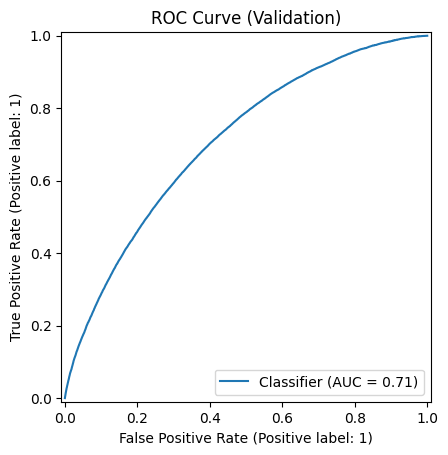

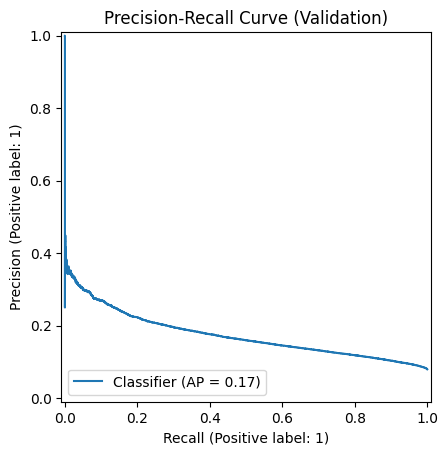

Confusion matrix @ threshold=0.05 (Validation):
[[ 48384 262602]
 [   776  26072]]

Confusion matrix @ threshold=0.10 (Validation):
[[153375 157611]
 [  5540  21308]]

Confusion matrix @ threshold=0.20 (Validation):
[[270204  40782]
 [ 17517   9331]]



/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Final evaluation metrics:


{'val_roc_auc': 0.708414993561522,
 'val_pr_auc': 0.17349293526854215,
 'val_brier': 0.07182944120743302,
 'test_roc_auc': 0.7050529012473593,
 'test_pr_auc': 0.055446577809493684,
 'test_brier': 0.03575879207675266}

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, confusion_matrix

# Clean test data: remove rows with missing targets (first time touching test)
valid_idx_test = y_test.notna()
X_test_clean = X_test[valid_idx_test].copy()
y_test_clean = y_test[valid_idx_test].copy().to_numpy().astype(int)

print(
    f"Test set: {X_test_clean.shape[0]} rows (removed {(~valid_idx_test).sum()} with missing target)"
)
print(f"Test target dtype: {y_test_clean.dtype}")

# Ensure categorical columns are strings in test
for col in cat_cols:
    if col in X_test_clean.columns:
        X_test_clean[col] = X_test_clean[col].astype(str)


def evaluate_split(y_true, proba, *, name: str):
    return {
        f"{name}_roc_auc": float(roc_auc_score(y_true, proba)),
        f"{name}_pr_auc": float(average_precision_score(y_true, proba)),
        f"{name}_brier": float(brier_score_loss(y_true, proba)),
    }


# Validation curves
RocCurveDisplay.from_predictions(y_val_clean, val_proba_best)
plt.title("ROC Curve (Validation)")
plt.show()

PrecisionRecallDisplay.from_predictions(y_val_clean, val_proba_best)
plt.title("Precision-Recall Curve (Validation)")
plt.show()


# Confusion matrix at reference thresholds
def cm_at_threshold(y_true, proba, thr: float):
    y_hat = (proba >= thr).astype(int)
    return confusion_matrix(y_true, y_hat)


for thr in [0.05, 0.10, 0.20]:
    cm = cm_at_threshold(y_val_clean, val_proba_best, thr)
    print(f"Confusion matrix @ threshold={thr:.2f} (Validation):\n{cm}\n")

# Held-out test evaluation (first time you should touch test)
test_proba = best_model.predict_proba(X_test_clean)[:, 1]
test_metrics = evaluate_split(y_test_clean, test_proba, name="test")
val_metrics = evaluate_split(y_val_clean, val_proba_best, name="val")

final_eval = {**val_metrics, **test_metrics}
print("Final evaluation metrics:")
final_eval

# 8. Probability Calibration

/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Raw test Brier: 0.035759
Calibrated test Brier: 0.027797


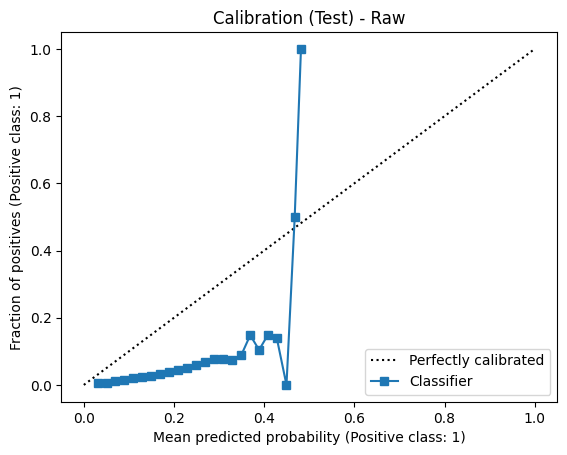

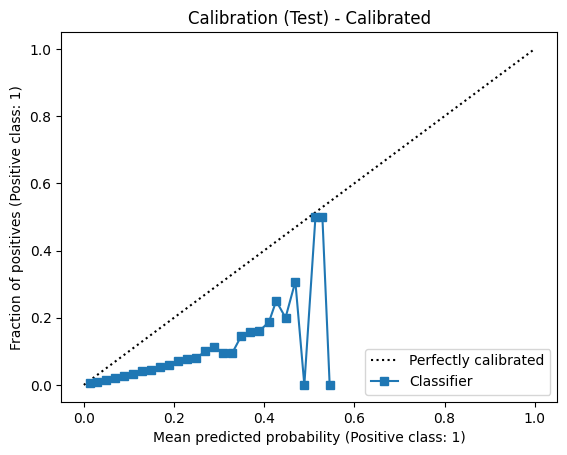

{'method': 'sigmoid',
 'fit_split': 'validation',
 'selected': True,
 'raw_test_brier': 0.03575879207675266,
 'cal_test_brier': 0.02779674726471248}

In [13]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

# Fit calibration using cleaned validation set ONLY (via prefit model)
# Note: CalibratedClassifierCV requires the base estimator to be fitted.
calibrator = CalibratedClassifierCV(gbdt_model, method="sigmoid", cv="prefit")
calibrator.fit(X_val_clean, y_val_clean)

# Compare raw vs calibrated on test (using cleaned test data)
raw_test_proba = test_proba
cal_test_proba = calibrator.predict_proba(X_test_clean)[:, 1]

raw_brier = float(brier_score_loss(y_test_clean, raw_test_proba))
cal_brier = float(brier_score_loss(y_test_clean, cal_test_proba))

print(f"Raw test Brier: {raw_brier:.6f}")
print(f"Calibrated test Brier: {cal_brier:.6f}")

CalibrationDisplay.from_predictions(y_test_clean, raw_test_proba, n_bins=50)
plt.title("Calibration (Test) - Raw")
plt.show()

CalibrationDisplay.from_predictions(y_test_clean, cal_test_proba, n_bins=50)
plt.title("Calibration (Test) - Calibrated")
plt.show()

calibration_choice = {
    "method": "sigmoid",
    "fit_split": "validation",
    "selected": True,
    "raw_test_brier": raw_brier,
    "cal_test_brier": cal_brier,
}
calibration_choice

# 9. Model Interpretability

In [ ]:
import pandas as pd

# Get feature names after preprocessing
pre = gbdt_model.named_steps["preprocess"]
clf = gbdt_model.named_steps["clf"]


# ColumnTransformer feature names helper (works for sklearn >=1.0-ish; may vary by version)
def get_feature_names(ct: ColumnTransformer):
    names = []
    for name, trans, cols in ct.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "get_feature_names_out"):
            # Pipeline: last step usually provides get_feature_names_out
            try:
                fn = trans.get_feature_names_out(cols)
            except TypeError:
                fn = trans.get_feature_names_out()
            names.extend(fn.tolist())
        else:
            names.extend([str(c) for c in cols])
    return names


feature_names = get_feature_names(pre)

if not hasattr(clf, "feature_importances_"):
    raise ValueError("This classifier does not expose feature_importances_.")

importances = clf.feature_importances_
imp = pd.DataFrame({"feature": feature_names, "importance": importances})
imp = imp.sort_values("importance", ascending=False).reset_index(drop=True)

print("Top 25 features:")
imp.head(25)

# 10. Stability & Robustness Checks

In [16]:
import pandas as pd
from sklearn.metrics import roc_auc_score

df_test_local = df_test.copy()
df_test_local[ANCHOR_COL] = pd.to_datetime(df_test_local[ANCHOR_COL])

# Choose slice granularity
df_test_local["slice"] = df_test_local[ANCHOR_COL].dt.to_period("M").astype(str)  # monthly

# Use calibrated or raw probabilities (choose one)
proba_for_stability = cal_test_proba  # calibrated

tmp = pd.DataFrame(
    {
        "slice": df_test_local["slice"].values,
        "y": y_test.astype(int).values,
        "p": proba_for_stability,
    }
)

rows = []
for s, g in tmp.groupby("slice"):
    if g["y"].nunique() < 2:
        continue  # skip slices with only one class
    rows.append(
        {
            "slice": s,
            "n": int(len(g)),
            "default_rate": float(g["y"].mean()),
            "roc_auc": float(roc_auc_score(g["y"], g["p"])),
            "avg_p": float(g["p"].mean()),
        }
    )

stability_df = pd.DataFrame(rows).sort_values("slice")
stability_df

,slice,n,default_rate,roc_auc,avg_p
0,2018-05,41220,0.049224,0.714953,0.079769
1,2018-06,41283,0.040889,0.721300,0.079588
2,2018-07,42791,0.031408,0.722324,0.081392
3,2018-08,45840,0.022644,0.724222,0.079733
4,2018-09,38803,0.019251,0.730212,0.078501
5,2018-10,46049,0.013616,0.716973,0.078097
6,2018-11,41844,0.010922,0.697479,0.080203
7,2018-12,40006,0.005774,0.686697,0.078726


# 11. Model Selection & Freezing

In [18]:
import hashlib
from datetime import datetime
from pathlib import Path

import joblib

ARTIFACTS_DIR = Path("../models/artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Decide final model object used for inference
# (If calibration improves Brier materially without hurting AUC too much, prefer it.)
final_model = gbdt_model  # or best_model
final_model_name = "gbdt_sigmoid_uncalibrated"  # update as needed

# Hash the feature spec to bind model to a contract
spec_path = Path(mi.metadata["spec_path"])
spec_bytes = spec_path.read_bytes()
feature_spec_hash = hashlib.sha256(spec_bytes).hexdigest()

model_version = f"{final_model_name}__{datetime.now().strftime('%Y%m%dT%H%M%SZ')}"

model_path = ARTIFACTS_DIR / f"{model_version}.joblib"
joblib.dump(final_model, model_path)

frozen_metadata = {
    "model_version": model_version,
    "model_name": final_model_name,
    "timestamp_utc": datetime.utcnow().isoformat() + "Z",
    "problem_freeze": problem_freeze,
    "split_meta": split_meta,
    "baseline_val_metrics": baseline_metrics,
    "tuned_val_metrics": tuned_val_metrics,
    "final_eval": final_eval,
    "calibration_choice": calibration_choice,
    "best_params": best_params,
    "feature_spec_hash": feature_spec_hash,
    "feature_cols": list(X_train.columns),
    "target": mi.target,
    "anchor_col": ANCHOR_COL,
}

META_DIR = Path("../models/metadata")
META_DIR.mkdir(parents=True, exist_ok=True)

meta_path = META_DIR / f"{model_version}__metadata.json"
meta_path.write_text(json.dumps(frozen_metadata, indent=2))

print("Frozen model + metadata saved:")
print(model_path)
print(meta_path)

Frozen model + metadata saved:
../models/artifacts/gbdt_sigmoid_uncalibrated__20251217T185001Z.joblib
../models/metadata/gbdt_sigmoid_uncalibrated__20251217T185001Z__metadata.json


/var/folders/xw/d_8wpw7j3d78hjl58tv4g7m00000gn/T/ipykernel_53195/3486581979.py:28: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp_utc": datetime.utcnow().isoformat() + "Z",


# 12. Serving Readiness Check (Contract + Smoke Test)

In [19]:
import pandas as pd

# 1) Validate feature ordering consistency
expected_feature_order = list(X_train.columns)


def prepare_payload(df_like: pd.DataFrame) -> pd.DataFrame:
    missing = [c for c in expected_feature_order if c not in df_like.columns]
    if missing:
        raise ValueError(f"Serving payload missing required features (sample): {missing[:25]}")
    # reorder and drop extras
    return df_like[expected_feature_order].copy()


# 2) Sample payload inference check
sample_payload = prepare_payload(X_test.head(5))
sample_scores = final_model.predict_proba(sample_payload)[:, 1]
print("Sample inference OK. Scores:", sample_scores)

# 3) Export a simple serving schema (name + dtype)
serving_schema = [
    {"name": c, "dtype": str(sample_payload[c].dtype)} for c in expected_feature_order
]
schema_path = ARTIFACTS_DIR / f"{model_version}__serving_schema.json"
schema_path.write_text(json.dumps(serving_schema, indent=2))

deployment_assumptions = {
    "input_schema": "serving_schema.json",
    "feature_ordering": "must match schema order",
    "anchor_time": ANCHOR_COL,
    "prediction": "PD at origination",
    "notes": [
        "Caller must provide all required features.",
        "Categoricals should use training-time coding; unknown categories handled by OHE(ignore).",
        "Datetime features were excluded from X (if drop_datetime_from_X=True).",
    ],
}
assumptions_path = ARTIFACTS_DIR / f"{model_version}__deployment_assumptions.json"
assumptions_path.write_text(json.dumps(deployment_assumptions, indent=2))

print("Serving artifacts written:")
print(schema_path)
print(assumptions_path)

Sample inference OK. Scores: [0.03383678 0.0318184  0.0880951  0.09185621 0.1499945 ]
Serving artifacts written:
../models/artifacts/gbdt_sigmoid_uncalibrated__20251217T185001Z__serving_schema.json
../models/artifacts/gbdt_sigmoid_uncalibrated__20251217T185001Z__deployment_assumptions.json


/Users/mcharris/Developer/mc-harris1/credit-risk-pd/.venv/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['recent_credit_inquiries_6m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
